In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from langchain.messages import AIMessage, HumanMessage, AnyMessage, ToolMessage, SystemMessage
from langchain.tools import tool
from langgraph.types import Command, Interrupt, Send
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Annotated, List, Optional, Union, Any, Literal
import os
from PIL import Image
from uuid import uuid4
import io
from fastapi import FastAPI
import sqlite3
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langgraph.prebuilt import ToolNode, ToolRuntime
from dataclasses import dataclass
from langgraph.runtime import Runtime
from langgraph.prebuilt import tools_condition, interrupt
from IPython.display import Image, display
from langgraph.types import Interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from datetime import datetime, timedelta
from random import randint
import base64
from datetime import datetime
load_dotenv()

True

In [2]:
class MainState(BaseModel):
    messages: Annotated[list[AnyMessage],add_messages]
    image_data: Optional[str]=None

@dataclass
class UserContext:
    userid: str
    username: str

DB_PATH="sales2.db"

class Product(BaseModel):
    category: Literal["Electronics","Audio","Computers","Footwear","Apparel","Printers","Wearables","Accessories","Home Appliances","Kitchen", "None"]

class SupervisorState(BaseModel):
    agent: Literal["OrdersAgent", "ProductsAgent","CartManagementAgent"]


In [3]:
# PROMPTS

SupervisorPrompt= """

    You are the Supervisor Agent.
    Your responsibility is to analyze the user’s query and select the correct agent to handle it.
    
    Choose the appropriate agent based on the intent of the user’s message:
    
    If the query is related to orders (order status, order details, placing order, cancelling order, delivery info, tracking) → choose "orders"
    
    If the query is related to products (finding products, categories, recommendations, product info, image-based discovery) → choose "products"
    
    If the query is related to the cart (viewing cart items, adding products to cart, cart totals, modifying cart, removing products from cart) → choose "Cart"

    User Query: {}

"""

OrderAgentPrompt="""

You are an Order Support AI Agent. Your job is to assist users with order questions, order tracking, and general support using the available tools.

Guidelines

User Assistance: Help users with any order-related queries, including tracking, placing orders, cancelling order, delivery updates, and pricing info.

Accurate Retrieval: Use tools like get_order_info to fetch complete order details. If the first attempt is insufficient, broaden the search and try again.

Personalized Responses: Address users by their name when available.

Goal

Provide clear, accurate, and friendly support for all order-related inquiries.

User Name: {}
"""

ProductsAgentPrompt="""

You are a Products Support AI Agent. Your role is to assist users with product discovery and recommendations based on category or images using the available tools.

Guidelines

User Assistance:
Help users explore products, find items by category, and get recommendations from uploaded images.

Accurate Retrieval:

Use get_products_based_on_category to fetch all products in a category.

Use get_product_recommendation_through_image to identify the product category from an image or return relevant product recommendations from image.
If the initial results are insufficient, broaden your request and try again.

Personalized Responses:
Address users by name when available.

Goal

Provide clear, accurate, and helpful product recommendations based on the user’s input.

User Name: {}


"""
CartManagementAgentPrompt="""

You are a Cart Management AI Agent. Your role is to assist users with all cart-related actions using the available tools.

Guidelines

User Assistance:
Help users view their cart items, add products to the cart, remove products from cart and understand cart totals or item details.

Accurate Tool Usage:

Use view_cart_items to fetch all items currently in the user's cart.

Use add_product_to_cart to add new products to the cart.
Use remove_product_from_cart to remove specific product from cart.
Always rely on tools for actual cart data—never assume or fabricate information.

Follow-Up When Needed:
If the user's request is unclear (e.g., missing product name or quantity), ask for the required details before calling a tool.

Personalized Responses:
Address users by their name when available.

Goal

Provide clear, accurate, and friendly support for all cart-related inquiries, ensuring users can easily review and modify their shopping cart.

Username: {}


"""

In [4]:
llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")
ProductsLLM=llm.with_structured_output(Product)

In [5]:
## ORDERS AGENT TOOLS

@tool
def get_order_info(orderid: str, runtime: ToolRuntime) -> dict:
    """ 

    Fetches the complete order information for a given Order ID.
    This includes the user's order details, current order status, shipping timelines, pricing information, ordered product information and the estimated number of days remaining for delivery.
    
    Returns:
    A dictionary containing:
    
    Order details (items, item details, quantity, order date, etc.)
    
    Order status (placed, packed, shipped, out for delivery, delivered, cancelled, etc.)
    
    Shipping information (shipping date, expected delivery date, transit updates)
    
    Price details (item price, taxes, discounts, total amount)

    
    Delivery estimate (remaining days to deliver the order)


    """

    
    userid = runtime.context.userid
    usernmae = runtime.context.username
    
    if not userid:
        raise ValueError("No User ID Configured.")
    if not orderid:
        raise ValueError("Order ID is not Informed.")

    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT o.order_id, o.order_date, o.total_amount, o.status, oi.item_id, oi.quantity, oi.price, pd.brand, pd.model, pd.specifications, s.shipped_date, s.delivery_date
        FROM orders o
        JOIN order_items oi ON oi.order_id = o.order_id
        JOIN product_details pd ON pd.product_id = oi.product_id
        JOIN shipping s ON s.order_id = oi.order_id
        WHERE o.order_id = ? AND o.user_id = ?

        """
    cur.execute(query,(orderid,userid))
    rows=cur.fetchall()
    column_names = [column[0] for column in cur.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cur.close()
    conn.close()
    return results

    
    
@tool
def show_all_orders(runtime: ToolRuntime) -> dict:
    """

        Retrieves a complete list of all orders associated with the user.
        
        This includes each order’s basic details, current status, shipping information, and pricing summary.
        
        Returns:
        A dictionary containing a list of all user orders, where each entry includes:
        
        Order ID
        
        Order status
        
        Order date
        
        Items and quantities
        
        Shipping details (shipping date, expected delivery date)
        
        Price summary (item total, taxes, discounts, final amount)

    """

    userid = runtime.context.userid
    usernmae = runtime.context.username
    
    if not userid:
        raise ValueError("No User ID Configured.")

    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT o.order_id, o.order_date, o.total_amount, o.status, oi.item_id, oi.quantity, oi.price, pd.brand, pd.model, pd.specifications, s.shipped_date, s.delivery_date
        FROM orders o
        JOIN order_items oi ON oi.order_id = o.order_id
        JOIN product_details pd ON pd.product_id = oi.product_id
        JOIN shipping s ON s.order_id = oi.order_id
        WHERE o.user_id = ?

        """
    cur.execute(query,(userid,))
    rows=cur.fetchall()
    column_names = [column[0] for column in cur.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cur.close()
    conn.close()
    return results

@tool
def place_order(productname: str, quantity: Optional[int]=1, *, runtime: ToolRuntime) -> str:
    """
        Creates a new order for the specified product with the given quantity. Quantity is optional by default it is one. It will updated once the 
        user sepcified quantity.
        This tool processes the order request and initiates the order placement workflow.
        
        Returns:
        A confirmation message indicating that the order has been successfully placed.
    
    """
    userid = runtime.context.userid
    usernmae = runtime.context.username
    
    if not userid:
        raise ValueError("No User ID Configured.")
    if not productname:
        return ValueError("Product Name is NOT Informed")

    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()

    orr=cur.execute("SELECT COUNT(*) FROM orders;")
    order_rows=orr.fetchone()
    oit=cur.execute("SELECT COUNT(*) FROM cart_items;")
    order_items_total=oit.fetchone()

    cur.execute("SELECT product_id, price FROM products WHERE name = ? ", (productname,))
    pid=cur.fetchone()
    product_id=pid
    if not product_id:
        
        cur.close()
        conn.close()
        
        return "No such Product to Order. Check Out some other Products"
    
    order_id=f"ORD-{str(datetime.now().year)}-0{order_rows[0]+5}"
    order_items_id=f"OIT-{str(datetime.now().year)}-0{order_items_total[0]+5}"
    shipping_id=f"SHP-{datetime.year}-0{order_items_total[0]+5}"
    order_date=str(datetime.now())
    shipped_date=str(datetime.now().date()+timedelta(randint(1,4)))
    delivery_date=str(datetime.now().date()+timedelta(randint(5,20)))
    shipping_satus="Processing"
    item_price=product_id[1]
    order_status="Processing"
    productID=product_id[0]
    total_order_price=quantity*item_price
    query1="INSERT INTO orders VALUES(?, ?, ?, ?, ?)"
    query2="INSERT INTO order_items VALUES (?, ?, ?, ?, ?)"
    query3="INSERT INTO shipping VALUES (?,?,?,?,?)"
    
    cur.execute(query1,(order_id,userid,order_date,total_order_price,order_status))
    cur.execute(query2,(order_items_id,order_id,productID, quantity, item_price))
    cur.execute(query3,(shipping_id,order_id,shipped_date,delivery_date,shipping_satus))
    conn.commit()
    cur.close()
    conn.close()
    return f"Your Order Product {productname} is Placed Successfully. Order Successfully Placed and check your order history about your product"

@tool
def cancel_order(order_id: str, runtime: ToolRuntime) -> str:
    """
        Cancels the user’s order associated with the provided Order ID.
        This tool verifies the order and processes the cancellation request.
        
        Returns:
        A confirmation message indicating whether the order was successfully canceled.
    """

    userid = runtime.context.userid
    usernmae = runtime.context.username
    
    if not userid:
        raise ValueError("No User ID Configured.")
    if not order_id:
        return ValueError("Order ID is NOT Informed")
    
    
    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT *
        FROM orders
        WHERE order_id = ? AND user_id = ?

        """
    orr=cur.execute(query,(order_id,userid))
    order_rows=orr.fetchone()
    if not order_rows:
        cur.close()
        conn.close()
        return f"No Existing Order found for the given order id: {order_id}."
    cur.execute("DELETE FROM orders WHERE order_id = ?", (order_id,))
    cur.execute("DELETE FROM order_items WHERE order_id = ?", (order_id,))
    cur.execute("DELETE FROM shipping WHERE order_id = ?", (order_id,))
    conn.commit()
    cur.close()
    conn.close()
    
    return f"Order {order_id} cancelled successfully."
    
    
    

## Products Agent Tools

@tool
def get_products_based_on_category(category: str, runtime: ToolRuntime) -> dict:
    """
        Fetches all available products belonging to the specified category.
        Provides detailed product information to help the user explore items within that category.
        
        Returns:
        A dictionary containing a list of products, where each product includes:
        
        Product name
        
        Product ID
        
        Description
        
        Category
        
        Price details
        
        Availability/stock status
        
        

    """

    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT p.name, p.category, pd.brand, pd.model, p.price,  pd.specifications, p.stock, p.description
        FROM products p
        JOIN product_details pd ON p.product_id = pd.product_id
        WHERE p.category = ?

        """
    cur.execute(query,(category,))
    rows=cur.fetchall()
    column_names = [column[0] for column in cur.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cur.close()
    conn.close()
    return results

@tool
def get_product_recommendation_through_image(runtime: ToolRuntime) -> dict:

    """

        Analyzes the provided product image and identifies the most relevant product category.
        Based on the detected category, the tool returns a list of recommended products that closely match or relate to the item in the image.
        Tool automatically calls when it is related to the products recommendation related to images
        
        Returns:
        A dictionary containing:
        
        Detected product category
        
        List of recommended products, each with:
        
        Product name
        
        Product ID
        
        Description
        
        Price details
        
        Availability/stock status

    """
    state=runtime.state
    #print(state)
    image_bytes=state.image_data
    if image_bytes is None:
        return "Image not found"
    
    mime_type = "image/jpeg"
    
    product_image=ProductsLLM.invoke([HumanMessage(
        content=[{"type": "text", "text": "Describe the local image."},
        {
            "type": "image",
            "base64": image_bytes,
            "mime_type": mime_type,
        },]
    )])
    category=product_image.category

    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT p.name, p.category, pd.brand, pd.model, p.price,  pd.specifications, p.stock, p.description
        FROM products p
        JOIN product_details pd ON p.product_id = pd.product_id
        WHERE p.category = ?

        """
    cur.execute(query,(category,))
    rows=cur.fetchall()
    column_names = [column[0] for column in cur.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cur.close()
    conn.close()
    return results


# Cart Management Agent Tools

@tool
def view_cart_items(runtime: ToolRuntime) -> dict:
    """
        Fetches all items currently present in the user’s cart.
        Provides detailed information for each item along with a complete cart summary.
        
        Returns:
        A dictionary containing:
        
        List of cart items, each with:
        
        Product name
        
        Product ID
        
        Quantity
        
        Price details
        
        Subtotal
        
        Overall cart summary, including total items and total cost.
    """
    
    userid = runtime.context.userid
    usernmae = runtime.context.username
    
    if not userid:
        raise ValueError("No User ID Configured.")
        
    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    query="""

        SELECT p.name, p.category, pd.brand, pd.model, p.price,  ci.quantity, pd.specifications, p.description
        FROM cart c
        JOIN cart_items ci ON ci.cart_id = c.cart_id
        JOIN products p ON p.product_id = ci.product_id
        JOIN product_details pd ON pd.product_id = p.product_id
        WHERE c.user_id = ?

        """
    cur.execute(query,(userid,))
    rows=cur.fetchall()
    column_names = [column[0] for column in cur.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cur.close()
    conn.close()
    return results

@tool
def add_product_to_cart(productname: str, quantity: Optional[int]=1,*, runtime: ToolRuntime) -> str:
    """
        Adds the specified product to the user’s cart with the given quantity. quantity is optional by default it is one if user provided then it will be updated.
        Returns:
            A confirmation message indicating that the product has been successfully added to the cart.

    """

    userid = runtime.context.userid
    username = runtime.context.username

    if not userid:
        raise ValueError("No User ID Configured.")

    if not productname:
        raise ValueError("Product Name not provided")
    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()

    cr=cur.execute("SELECT COUNT(*) FROM cart;")
    cart_rows=cr.fetchone()
    
    print(cart_rows)
    cit=cur.execute("SELECT COUNT(*) FROM cart_items;")
    cart_items_total=cit.fetchone()
    print(cart_items_total)

    cur.execute("SELECT product_id FROM products WHERE name = ? ", (productname,))
    pid=cur.fetchone()
    product_id=pid
    if not product_id:
        
        cur.close()
        conn.close()
        
        return "No such Product to Order. Check Out some other Products"

    check_product_already_exists_in_cart_query="""

    SELECT * 
    FROM cart c
    JOIN cart_items ci ON c.cart_id = ci.cart_id
    WHERE c.user_id = ? and ci.product_id = ?

    """
    cur.execute(check_product_already_exists_in_cart_query,(userid,product_id[0]))
    existing_=cur.fetchall()
    if existing_:
        cur.close()
        conn.close()
        return f"Product {productname} already in your cart"
        
    print(product_id)
    # cid=cur.execute("SELECT cart_id FROM cart WHERE user_id = ? ", (userid,))
    # cID=cid.fetchone()
    # cart_id=cID[0]
    cart_id=f"CRT-{str(datetime.now().year)}-{cart_rows[0]+5}"
    cart_user_id=userid
    cart_time_stamp=str(datetime.now())

    cart_items_id=f"CIT-{str(datetime.now().year)}-{cart_items_total[0]+5}"

    query1="INSERT INTO cart VALUES(?, ?, ?)"
    query2="INSERT INTO cart_items VALUES (?, ?, ?, ?)"

    cur.execute(query1,(cart_id,userid,cart_time_stamp))
    cur.execute(query2,(cart_items_id, cart_id, product_id[0], quantity))
    conn.commit()

    cur.close()
    conn.close()
    return f"Product {productname} added to {username}'s cart successfully."
    
@tool
def remove_product_from_cart(productname: str, runtime: ToolRuntime) -> str:
    """
        Removes the specified product from the user’s cart.
        This tool searches the cart for the given product name and deletes it if found.
        
        Returns:
        A confirmation message indicating whether the product was successfully removed from the cart

    """

    userid = runtime.context.userid
    username = runtime.context.username

    if not userid:
        raise ValueError("No User ID Configured.")

    if not productname:
        raise ValueError("Product Name not provided")
        
    conn=sqlite3.connect(DB_PATH)
    cur=conn.cursor()
    cur.execute("SELECT product_id FROM products WHERE name = ? ", (productname,))
    pid=cur.fetchone()
    product_id=pid
    if not product_id:
        
        cur.close()
        conn.close()
        
        return "No such Product to Order. Check Out some other Products"
    query="""

        SELECT ci.item_id
        FROM cart c
        JOIN cart_items ci ON ci.cart_id = c.cart_id
        WHERE c.user_id = ? AND ci.product_id = ?

    """
    cart_item=cur.execute(query,(userid,product_id[0]))
    CartItem=cart_item.fetchone()
    if not CartItem:
        cur.close()
        conn.close()
        return f"{productname} is not available in your cart"
    cur.execute("DELETE FROM cart_items WHERE item_id = ?",(CartItem[0],))
    conn.commit()
    cur.close()
    conn.close()

    return f"Product {productname} is removed from cart successfully."
    

In [6]:
llm=ChatGoogleGenerativeAI(model="gemini-2.5-flash")
ProductsLLM=llm.with_structured_output(Product)
OrdersAgentLLM=llm.bind_tools([get_order_info, show_all_orders, place_order, cancel_order])
ProductsAgentLLM=llm.bind_tools([get_products_based_on_category, get_product_recommendation_through_image])
CartAgentLLM=llm.bind_tools([view_cart_items,add_product_to_cart,remove_product_from_cart])

In [7]:
memory=MemorySaver()

thread_id=str(uuid4())

config={
    "configurable": {
                "thread_id": thread_id,
            }
}

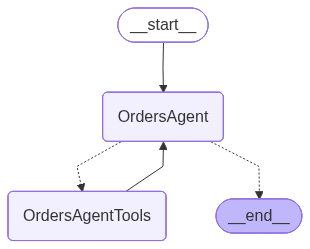

In [8]:
def OrdersAgent(state: MainState, runtime: Runtime[UserContext]):
    uname=runtime.context.username
    
    response=OrdersAgentLLM.invoke(

        [
            SystemMessage(content=OrderAgentPrompt.format(uname))
        ] + state.messages
    )
    if isinstance(response.content,list):
        if "text" in response.content[0]:
            return {"messages":AIMessage(content=response.content[0]["text"])}
        return {"messages":AIMessage(content="")}
    return {"messages":response}



         

def handle_tool_error(e: ValueError) -> str:
    return f"Invalid input provided, {e}"

orders_tool_node=ToolNode([get_order_info, show_all_orders, place_order, cancel_order], handle_tool_errors=handle_tool_error)

def OrdersAgentToolsCondition(state: MainState) -> Literal["OrdersAgent",END]:
    if state.messages[-1].tool_calls:
        return "OrdersAgentTools"
    return END

OrdersWorkflow=StateGraph(MainState, context_schema=UserContext)
OrdersWorkflow.add_node("OrdersAgent",OrdersAgent)
OrdersWorkflow.add_node("OrdersAgentTools",orders_tool_node)
OrdersWorkflow.add_edge(START,"OrdersAgent")
OrdersWorkflow.add_conditional_edges("OrdersAgent",OrdersAgentToolsCondition,["OrdersAgentTools",END])
OrdersWorkflow.add_edge("OrdersAgentTools","OrdersAgent")
OrdersWorkflow.add_edge("OrdersAgent",END)

OrdersGraph=OrdersWorkflow.compile(checkpointer=memory)

display(Image(OrdersGraph.get_graph().draw_mermaid_png()))

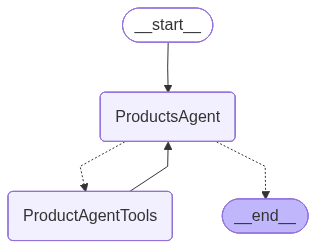

In [9]:
def ProductsAgent(state: MainState, runtime: Runtime[UserContext]):
    uname=runtime.context.username
    
    response=ProductsAgentLLM.invoke(

        [
            SystemMessage(content=ProductsAgentPrompt.format(uname))
        ] + state.messages
    )
    if isinstance(response.content,list):
        if "text" in response.content[0]:
            return {"messages":AIMessage(content=response.content[0]["text"])}
        return {"messages":AIMessage(content="")}
    return {"messages":response}



         

def handle_tool_error(e: ValueError) -> str:
    return f"Invalid input provided, {e}"

products_tool_node=ToolNode([get_products_based_on_category,get_product_recommendation_through_image], handle_tool_errors=handle_tool_error)

def product_tools_condition(state: MainState) -> Literal["ProductsAgent",END]:
    if state.messages[-1].tool_calls:
        return "ProductAgentTools"
    return END


products_Workflow=StateGraph(MainState, context_schema=UserContext)
products_Workflow.add_node("ProductsAgent",ProductsAgent)
products_Workflow.add_node("ProductAgentTools",products_tool_node)
products_Workflow.add_edge(START,"ProductsAgent")
products_Workflow.add_conditional_edges("ProductsAgent",product_tools_condition,["ProductAgentTools",END])
products_Workflow.add_edge("ProductAgentTools","ProductsAgent")
products_Workflow.add_edge("ProductsAgent",END)

ProductsGraph=products_Workflow.compile(checkpointer=memory)
display(Image(ProductsGraph.get_graph().draw_mermaid_png()))

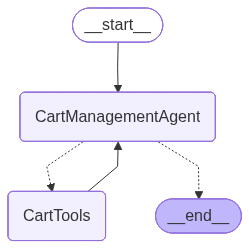

In [10]:
def CartManagementAgent(state: MainState, runtime: Runtime[UserContext]):
    uname=runtime.context.username
    
    response=CartAgentLLM.invoke(

        [
            SystemMessage(content=CartManagementAgentPrompt.format(uname))
        ] + state.messages
    )
    if isinstance(response.content,list):
        if "text" in response.content[0]:
            return {"messages":AIMessage(content=response.content[0]["text"])}
        return {"messages":AIMessage(content="")}
    return {"messages":response}


cart_tools_node=ToolNode([view_cart_items,add_product_to_cart,remove_product_from_cart], handle_tool_errors=handle_tool_error)

def cart_tools_condition(state: MainState) -> Literal["CartManagementAgent",END]:
    if state.messages[-1].tool_calls:
        return "CartTools"
    return END 
    
cart_Workflow=StateGraph(MainState, context_schema=UserContext)
cart_Workflow.add_node("CartManagementAgent",CartManagementAgent)
cart_Workflow.add_node("CartTools",cart_tools_node)
cart_Workflow.add_edge(START,"CartManagementAgent")
cart_Workflow.add_conditional_edges("CartManagementAgent",cart_tools_condition,["CartTools",END])
cart_Workflow.add_edge("CartTools","CartManagementAgent")
cart_Workflow.add_edge("CartManagementAgent",END)

CartGraph=cart_Workflow.compile(checkpointer=memory)
display(Image(CartGraph.get_graph().draw_mermaid_png()))

In [11]:
def pil_to_bytes(pil_img, format="PNG"):
    
    buf = io.BytesIO()
    pil_img.save(buf, format=format)
    return buf.getvalue()



In [12]:
SupervisorLLM=llm.with_structured_output(SupervisorState)

In [13]:
class MainAgentState(BaseModel):
    messages: Annotated[list[AnyMessage],add_messages]
    agent: Optional[str]=None
    image_data: Optional[str]=None

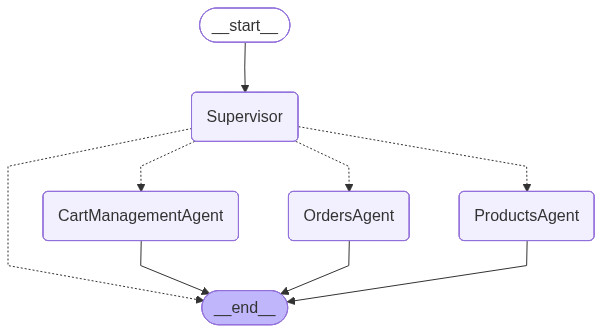

In [14]:
def Supervisor(state: MainAgentState, runtime: Runtime[UserContext]):
    last_message=state.messages[-1].content
    decision=SupervisorLLM.invoke(SupervisorPrompt.format(last_message))
    agent=decision.agent
    state.agent=agent
    print(f"CALLING AGENT: {agent}")
    return state


def router(state: MainAgentState, runtime: Runtime[UserContext]) -> Literal["OrdersAgent", "ProductsAgent","CartManagementAgent", END]:
    if state.agent:
        return state.agent
    return END


def SubOrdersAgent(state: MainAgentState, runtime: Runtime[UserContext]):
    uid=runtime.context.userid
    uname=runtime.context.username
    last_message=state.messages[-1].content
    order_events=OrdersGraph.invoke({"messages":[HumanMessage(content=last_message)]},
    context=UserContext(userid=uid, username=uname),config=config)
    response=order_events["messages"][-1]
    return {"messages":response}

def SubProductsAgent(state: MainAgentState, runtime: Runtime[UserContext]):
    uid=runtime.context.userid
    uname=runtime.context.username
    last_message=state.messages[-1].content
    img_bytes=state.image_data
    product_events=ProductsGraph.invoke({"messages":[HumanMessage(content=last_message)],"image_data":img_bytes},
    context=UserContext(userid=uid, username=uname),config=config)
    response=product_events["messages"][-1]
    return {"messages":response}

def SubCartAgent(state: MainAgentState, runtime: Runtime[UserContext]):
    uid=runtime.context.userid
    uname=runtime.context.username
    last_message=state.messages[-1].content
    print(last_message)
    cart_events=CartGraph.invoke({"messages":[HumanMessage(content=last_message)]},
    context=UserContext(userid=uid, username=uname),config=config)
    print(cart_events)
    response=cart_events["messages"][-1]
    print(response)
    return {"messages":response}


MultiAgentWorkflow=StateGraph(MainAgentState, context_schema=UserContext)
MultiAgentWorkflow.add_node("Supervisor",Supervisor)
MultiAgentWorkflow.add_node("OrdersAgent",SubOrdersAgent)
MultiAgentWorkflow.add_node("ProductsAgent",SubProductsAgent)
MultiAgentWorkflow.add_node("CartManagementAgent",SubCartAgent)
MultiAgentWorkflow.add_edge(START,"Supervisor")
MultiAgentWorkflow.add_conditional_edges("Supervisor",router, ["OrdersAgent", "ProductsAgent","CartManagementAgent",END])
MultiAgentWorkflow.add_edge("OrdersAgent",END)
MultiAgentWorkflow.add_edge("ProductsAgent",END)
MultiAgentWorkflow.add_edge("CartManagementAgent",END)
MultiAgentWorkflow.add_edge("Supervisor",END)
MultiAgenticGraph=MultiAgentWorkflow.compile(checkpointer=memory)
display(Image(MultiAgenticGraph.get_graph().draw_mermaid_png()))

In [15]:
config

{'configurable': {'thread_id': 'ecbcacf7-d4f6-46ad-aa5a-903972a85207'}}

In [17]:
from PIL import Image
img = Image.open(r"C:\Users\Varun Sai Kanuri\Downloads\headphones.png")
img_bytes = pil_to_bytes(img)

In [18]:
img_b64 = base64.b64encode(img_bytes).decode()

In [19]:
agentEvnets=MultiAgenticGraph.invoke({"messages":[HumanMessage(content="can you please show products related to the image")],"image_data":img_b64},
    context=UserContext(userid="USR-2025-001", username="Aakash Sharma"),config=config)

for event in agentEvnets["messages"]:
    print(event.pretty_print())

C:\Generative AI\PythonFullStack\genai\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


CALLING AGENT: ProductsAgent


C:\Generative AI\PythonFullStack\genai\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[any, any]` - serialized value may not be as expected [field_name='state', input_value=MainState(messages=[Human...Ru3XA2AAAAAElFTkSuQmCC'), input_type=MainState])
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=UserContext(userid='USR-2...sername='Aakash Sharma'), input_type=UserContext])
  return self.__pydantic_serializer__.to_python(


================================ Human Message =================================

can you please show products related to the image
None
================================== Ai Message ==================================

Aakash Sharma, I found some products related to the image you provided:

**Sony WH-1000XM5 Headphones**
*   **Category:** Audio
*   **Description:** Noise-cancelling wireless headset
*   **Price:** ₹29,999
*   **Stock:** 58 available

**Boat Airdopes 200**
*   **Category:** Audio
*   **Description:** TWS earbuds with long battery
*   **Price:** ₹1,999
*   **Stock:** 220 available

Both of these are in the Audio category. Let me know if you'd like to explore other categories or have any more questions!
None


In [21]:
agentEvnets

{'messages': [HumanMessage(content='can you show all items in my Cart', additional_kwargs={}, response_metadata={}, id='e17c8267-16b5-4a95-8622-b7c43d406f17'),
  AIMessage(content='Certainly, Aakash Sharma! Here are the items currently in your cart:\n\n*   **Apple iPhone 15 Pro Max**: 1 piece, priced at Rs. 129999\n*   **Nike Air Max 270**: 2 pieces, priced at Rs. 12999 each\n*   **Sony WH-1000XM5 Headphones**: 1 piece, priced at Rs. 29999\n\nIs there anything else I can help you with regarding your cart?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--f2714ef9-216c-4039-9d1d-e3faecb84d9c-0', usage_metadata={'input_tokens': 811, 'output_tokens': 113, 'total_tokens': 924, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='please add Apple Watch Series 10 item into my cart', additional_kwa

In [38]:
for event in agentEvnets["messages"]:
    print(event.pretty_print())

================================ Human Message =================================

can you show all items in my Cart
None
================================ Human Message =================================

can you show all items in my Cart
None
================================ Human Message =================================

can you show all items in my Cart
None
================================== Ai Message ==================================

Aakash, here are the items in your cart:

*   **Apple iPhone 15 Pro Max** - 129999 x 1
*   **Nike Air Max 270** - 12999 x 2
*   **Sony WH-1000XM5 Headphones** - 29999 x 1
*   **Apple Watch Series 10** - 45999 x 1

Is there anything else I can help you with today?
None


In [21]:
from PIL import Image

In [22]:
img = Image.open(r"C:\Users\Varun Sai Kanuri\Downloads\headphones.png")
img_bytes = pil_to_bytes(img)

In [23]:
agentEvnets=MultiAgenticGraph.invoke({"messages":[HumanMessage(content="can you please show some products related to the image")],"image_data":img_bytes},
    context=UserContext(userid="USR-2025-001", username="Aakash Sharma"),config=config)

for event in agentEvnets["messages"]:
    print(event.pretty_print())

CALLING AGENT: ProductsAgent


C:\Generative AI\PythonFullStack\genai\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[any, any]` - serialized value may not be as expected [field_name='state', input_value=MainState(messages=[Human...\x00\x00IEND\xaeB`\x82'), input_type=MainState])
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='context', input_value=UserContext(userid='USR-2...sername='Aakash Sharma'), input_type=UserContext])
  return self.__pydantic_serializer__.to_python(


================================ Human Message =================================

please place an Nike Air Max 270 order for me. 
None
================================== Ai Message ==================================

Aakash Sharma, your order for Nike Air Max 270 has been placed successfully! You can check your order history for more details.
None
================================ Human Message =================================

can you please show all my orders
None
================================== Ai Message ==================================

Here is a list of all your orders, Aakash Sharma:

**Order ID: ORD-2025-001**
*   **Product:** iPhone 15 Pro Max
*   **Quantity:** 1
*   **Order Date:** 2025-11-05
*   **Status:** Processing
*   **Expected Delivery:** 2025-11-10
*   **Total Amount:** ₹129,999

**Order ID: ORD-2025-002**
*   **Product:** Watch Series 10
*   **Quantity:** 1
*   **Order Date:** 2025-11-10
*   **Status:** Delivered
*   **Expected Delivery:** 2025-11-15
*   **Total

In [78]:
agentEvnets=MultiAgenticGraph.invoke({"messages":[HumanMessage(content="can you please show all my orders")],"image_data":img_bytes},
    context=UserContext(userid="USR-2025-001", username="Aakash Sharma"),config=config)

for event in agentEvnets["messages"]:
    print(event.pretty_print())

================================ Human Message =================================

can you please show some products related to the image
None
================================== Ai Message ==================================

Aakash Sharma, I've analyzed the image and found some audio products that might interest you:

*   **Sony WH-1000XM5 Headphones**:
    *   **Category**: Audio
    *   **Description**: Noise-cancelling wireless headset
    *   **Price**: ₹29,999
    *   **Stock**: 58 available

*   **Boat Airdopes 200**:
    *   **Category**: Audio
    *   **Description**: TWS earbuds with long battery
    *   **Price**: ₹1,999
    *   **Stock**: 220 available

These recommendations are based on the product image you provided. Let me know if you'd like to explore other categories or products!
None
================================ Human Message =================================

can you please show all my orders
None
================================== Ai Message ======================